<a href="https://colab.research.google.com/github/ShahistaAfreen/DL_A1/blob/main/DL_A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.datasets import mnist, fashion_mnist
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import warnings
warnings.filterwarnings("ignore")
import wandb
import seaborn as sns

In [2]:
wandb.login() # Login

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: na21b050 (na21b050-iit-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

# **Data Preprocessing**

In [3]:
# Load dataset
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

# Normalize pixel values to the range [0,1]
X_train = X_train.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255

# Reshape data: flatten 28x28 images into vectors
num_features = X_train.shape[1] * X_train.shape[2]
X_train = X_train.reshape(-1, num_features).T
X_test = X_test.reshape(-1, num_features).T

# Split dataset: 90% training, 10% validation
X_train, X_val, y_train, y_val = train_test_split(X_train.T, y_train, test_size=0.1, random_state=42)
X_train, X_val = X_train.T, X_val.T

# Determine dataset sizes
M, Mval, Mtest = X_train.shape[1], X_val.shape[1], X_test.shape[1]

# Identify number of classes
num_classes = np.max(y_train) + 1

# Convert labels to one-hot encoded format
y_train_one_hot = np.eye(num_classes)[y_train].T
y_val_one_hot = np.eye(num_classes)[y_val].T
y_test_one_hot = np.eye(num_classes)[y_test].T

# Display dataset details
print(f"Training samples: {M}")
print(f"Validation samples: {Mval}")
print(f"Test samples: {Mtest}")
print(f"Total classes: {num_classes}")
print(f"Features per sample: {num_features}")


Training samples: 54000
Validation samples: 6000
Test samples: 10000
Total classes: 10
Features per sample: 784


# **Q1 : Printing sample images of each class**

**Class Names**

In [4]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

**Function that returns the 1st indices of the each class**

In [5]:
def find_first_indexes(lst):
    first_indexes = {}

    for i, val in enumerate(lst):
        if val in range(10) and val not in first_indexes:
            first_indexes[val] = i

        if len(first_indexes) == 10:  # Stop once we have all 10 values
            break

    return first_indexes

**Printing in colab using Matplotlib**

{5: 0, 2: 1, 9: 2, 0: 3, 7: 6, 1: 9, 8: 16, 6: 17, 3: 24, 4: 27}


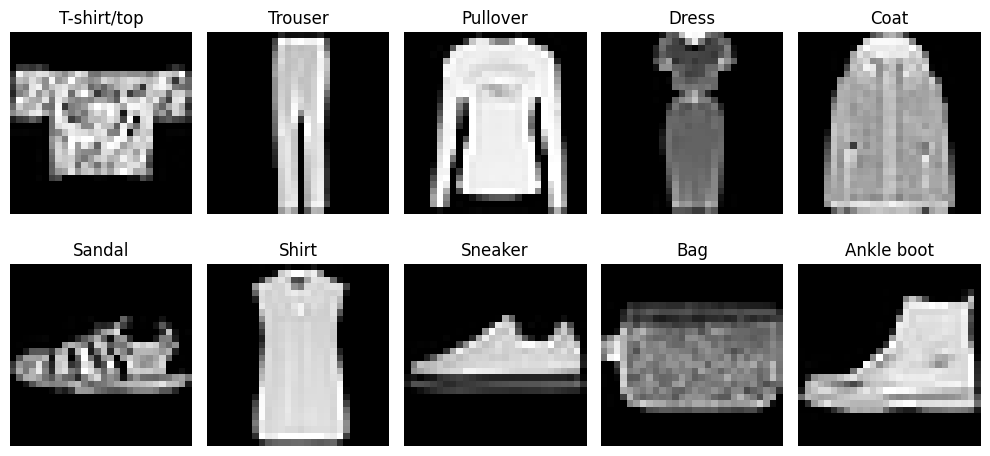

In [6]:
# Get first indexes
first_indexes = find_first_indexes(y_train)

print(first_indexes)
# Create subplots
fig, axes = plt.subplots(2, 5, figsize=(10, 5))

for class_num, idx in first_indexes.items():
    row, col = divmod(class_num, 5)  # Position in the 2x5 grid
    axes[row, col].imshow(X_train[:, idx].reshape(28, 28), cmap="gray")
    axes[row, col].set_title(class_names[class_num])
    axes[row, col].axis("off")

plt.tight_layout()
plt.show()

**Printing images in wandb**

In [7]:
# Initialize a new wandb run
run = wandb.init(
    project="Plotting images from each class",
    notes="Logging one sample image per class",
    settings=wandb.Settings(init_timeout=90),
    config={}
)

# Store the index of the first occurrence of each class
first_indices = first_indexes

# Prepare images and captions
images = []
captions = []
for clas, index in first_indices.items():
    images.append(X_train.T[index].reshape((28, 28)))  # Reshape to 28x28 for visualization
    captions.append(class_names[clas])

# Log images to Weights & Biases
wandb.log({
    "Sample Image from each class": [
        wandb.Image(image, caption=caption) for image, caption in zip(images, captions)
    ]
})

wandb.finish()

# **Q2 : Neural Network**

# **Activation functions & corresponding dervatives**

In [8]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def d_sigmoid(x):
    s = sigmoid(x)
    return s * (1 - s)

def tanh(x):
    return np.tanh(x)

def d_tanh(x):
    return 1 - np.tanh(x) ** 2

def relu(x):
    return np.maximum(0, x)

def d_relu(x):
    return (x > 0).astype(float)

def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=0, keepdims=True))
    return exp_x / np.sum(exp_x, axis=0, keepdims=True)

def d_softmax(x):
    s = softmax(x)
    return s * (1 - s)

# **Cost function : Cross Entropy**

In [9]:
# Computes loss for multi-class classification with optional L2 regularization.
# Supports 'categorical_crossentropy' and 'mse' loss types.

def compute_loss_multi(Y_true, Y_pred, batch_len, loss_type, lambda_val, params):
    if loss_type == 'categorical_crossentropy':
        total_loss = -np.sum(Y_true * np.log(Y_pred)) / batch_len
    elif loss_type == 'mse':
        total_loss = 0.5 * np.sum((Y_true - Y_pred) ** 2) / batch_len
    else:
        raise ValueError("Unsupported loss function!")

    # L2 Regularization term
    reg_penalty = sum(np.linalg.norm(params[f"W{i}"])**2 for i in range(1, len(params)//2 + 1))

    # Final loss with regularization
    total_loss += (lambda_val / (2 * batch_len)) * reg_penalty

    return total_loss


# **Intializing params**

In [10]:
# Initializes weights and biases for a neural network using different initialization methods.
# Supports "xavier", "random_uniform", and "random_normal".
# Also initializes a dictionary to store previous updates for optimization.

def init_nn_parameters(layers, mode="xavier"):
    weights_biases = {}
    prev_updates = {}

    for i in range(1, len(layers)):
        np.random.seed(42)  # Ensuring reproducibility

        if mode == "xavier":
            scale_factor = np.sqrt(1 / layers[i - 1])
            weights_biases[f"W{i}"] = np.random.randn(layers[i], layers[i - 1]) * scale_factor
        elif mode == "random_uniform":
            weights_biases[f"W{i}"] = np.random.rand(layers[i], layers[i - 1]) * 0.01
        else:  # Handles "random_normal" or any other unlisted mode
            weights_biases[f"W{i}"] = np.random.randn(layers[i], layers[i - 1]) * 0.01

        weights_biases[f"b{i}"] = np.zeros((layers[i], 1))

    prev_updates = {k: np.zeros_like(v) for k, v in weights_biases.items()}

    return weights_biases, prev_updates


# **Forward Propagation**

In [11]:
# Performs forward propagation in a neural network for a mini-batch.
# Uses an activation function ('sigmoid', 'relu', or 'tanh') for hidden layers.
# Returns the final output, along with activations and pre-activations for all layers.

def forward_propagation_nn(X, weights, act_func):

    num_layers = len(weights) // 2 + 1
    activations = [None] * num_layers
    pre_activations = [None] * num_layers

    activations[0] = X  # Input is the first activation

    # Activation function mapping
    activation_map = {'sigmoid': sigmoid, 'relu': relu, 'tanh': tanh}

    for l in range(1, num_layers):
        W, b = weights[f"W{l}"], weights[f"b{l}"]
        pre_activations[l] = np.dot(W, activations[l - 1]) + b

        if l == num_layers - 1:
            activations[l] = softmax(pre_activations[l])  # Output layer uses softmax
        else:
            if act_func in activation_map:
                activations[l] = activation_map[act_func](pre_activations[l])
            else:
                raise ValueError(f"Unsupported activation function: {act_func}")

    final_output = activations[-1]

    return final_output, activations, pre_activations


# **back propagation**

In [14]:
# Computes gradients using backpropagation for a mini-batch in a neural network.
# Supports 'mse' and 'categorical_crossentropy' loss functions.
# Applies L2 regularization and updates gradients for all layers.

def compute_gradients_backprop(Y_pred, Y_True, activations, pre_activations, weights, act_func, batch_size, loss_type, reg_lambda):
    num_layers = len(weights) // 2
    grads = {}

    if loss_type == 'categorical_crossentropy':
        grads[f"dZ{num_layers}"] = activations[num_layers] - Y_True
    elif loss_type == 'mse':
        grads[f"dZ{num_layers}"] = (activations[num_layers] - Y_True) * d_softmax(pre_activations[num_layers])

    activation_derivatives = {'sigmoid': d_sigmoid, 'relu': d_relu, 'tanh': d_tanh}

    for layer in range(num_layers, 0, -1):
        grads[f"dW{layer}"] = (np.dot(grads[f"dZ{layer}"], activations[layer - 1].T) + reg_lambda * weights[f"W{layer}"]) / batch_size
        grads[f"db{layer}"] = np.sum(grads[f"dZ{layer}"], axis=1, keepdims=True) / batch_size

        if layer > 1:
            if act_func in activation_derivatives:
                grads[f"dZ{layer-1}"] = np.dot(weights[f"W{layer}"].T, grads[f"dZ{layer}"]) * activation_derivatives[act_func](pre_activations[layer - 1])
            else:
                raise ValueError(f"Unsupported activation function: {act_func}")

    return grads


# **Optimizers**

In [15]:
#SGD update

def sgd(parameters,grads,learning_rate):
    L = len(parameters) // 2

    for l in range(1, L + 1):
        parameters["W" + str(l)] = parameters["W" + str(l)] - learning_rate * grads["dW" + str(l)]
        parameters["b" + str(l)] = parameters["b" + str(l)] - learning_rate * grads["db" + str(l)]

    return parameters

# Momentum update

def momentum(parameters, grads, learning_rate, beta, previous_updates):
    L = len(parameters) // 2 # number of layers in the neural network

    for l in range(1, L + 1):
        previous_updates["W"+str(l)] = beta*previous_updates["W"+str(l)] + (1-beta)*grads["dW" + str(l)]
        parameters["W" + str(l)] = parameters["W" + str(l)] - learning_rate*previous_updates["W"+str(l)]

        previous_updates["b"+str(l)] = beta*previous_updates["b"+str(l)] + (1-beta)*grads["db" + str(l)]
        parameters["b" + str(l)] = parameters["b" + str(l)] - learning_rate*previous_updates["b"+str(l)]

    return parameters, previous_updates

# RMSprop update

def RMSprop(parameters, grads, learning_rate, beta, v):
    L = len(parameters) // 2 # number of layers in the neural network
    delta = 1e-6 # for numerical stability

    for l in range(1, L + 1):
        vdw = beta*v["W" + str(l)] + (1-beta)*np.multiply(grads["dW" + str(l)],grads["dW" + str(l)])
        vdb = beta*v["b" + str(l)] + (1-beta)*np.multiply(grads["db" + str(l)],grads["db" + str(l)])

        parameters["W" + str(l)] = parameters["W" + str(l)] - learning_rate * grads["dW" + str(l)] / (np.sqrt(vdw)+delta)
        parameters["b" + str(l)] = parameters["b" + str(l)] - learning_rate * grads["db" + str(l)] / (np.sqrt(vdb)+delta)

        v["W" + str(l)] = vdw
        v["b" + str(l)] = vdb

    return parameters,v


# Adam optimizer update

def adam(parameters, grads, learning_rate, v, m, t):
    L = len(parameters) // 2 # number of layers in the neural network
    beta1 = 0.9
    beta2 = 0.999
    epsilon = 1e-8

    for l in range(1, L+1):
        mdw = beta1*m["W"+str(l)] + (1-beta1)*grads["dW"+str(l)]
        vdw = beta2*v["W"+str(l)] + (1-beta2)*np.square(grads["dW"+str(l)])
        mw_hat = mdw/(1.0 - beta1**t)
        vw_hat = vdw/(1.0 - beta2**t)

        parameters["W"+str(l)] = parameters["W"+str(l)] - (learning_rate * mw_hat)/np.sqrt(vw_hat + epsilon)

        mdb = beta1*m["b"+str(l)] + (1-beta1)*grads["db"+str(l)]
        vdb = beta2*v["b"+str(l)] + (1-beta2)*np.square(grads["db"+str(l)])
        mb_hat = mdb/(1.0 - beta1**t)
        vb_hat = vdb/(1.0 - beta2**t)

        parameters["b"+str(l)] = parameters["b"+str(l)] - (learning_rate * mb_hat)/np.sqrt(vb_hat + epsilon)

        v["dW"+str(l)] = vdw
        m["dW"+str(l)] = mdw
        v["db"+str(l)] = vdb
        m["db"+str(l)] = mdb

    t = t + 1 # timestep
    return parameters, v, m, t

In [16]:
def plot_cost_curve(train_costs, val_costs):
    plt.figure(figsize=(8, 5))
    epochs = range(len(train_costs))

    plt.plot(epochs, train_costs, 'r-o', label="Training loss", lw=2, markersize=4)
    plt.plot(epochs, val_costs, 'g-s', label="Validation loss", lw=2, markersize=4)

    plt.title("Training and Validation Loss vs Number of Epochs", fontsize=14)
    plt.xlabel("Number of Epochs", fontsize=12)
    plt.ylabel("Loss", fontsize=12)

    plt.grid(True, linestyle="--", alpha=0.6)
    plt.legend()

    plt.tick_params(axis='both', labelsize=10)
    plt.show()


# **Prediction**

In [17]:
# Perform forward propagation and return predicted class labels
def predict_nn(X, parameters, act_func):
  output, _, _ = forward_propagation_nn(X, parameters, act_func)
  return np.argmax(output, axis=0)

# **Evaluation**

In [18]:
def evaluate_nn(X_train, y_train, X_test, y_test, parameters, act_func):
     # Predict labels for training and test sets
    y_train_pred = predict_nn(X_train, parameters, act_func)
    y_test_pred = predict_nn(X_test, parameters, act_func)

    # Compute accuracy scores
    train_acc = round(accuracy_score(y_train, y_train_pred) * 100, 3)
    test_acc = round(accuracy_score(y_test, y_test_pred) * 100, 3)

    # Display results
    print(f"Training Accuracy: {train_acc} %")
    print(f"Test Accuracy: {test_acc} %")

    # Print classification report for test set
    print("\nClassification Report (Test Set):")
    print(classification_report(y_test, y_test_pred))

    return y_train_pred, y_test_pred

# **Fitting Neural Network**

In [20]:
def NN_fit():
    """
    Trains a neural network using different optimization algorithms (SGD, Momentum, RMSprop, Adam, Nesterov, Nadam).
    Logs training progress using Weights & Biases (wandb) and plots the cost curve at the end.

    Returns:
        params (dict): Trained model parameters.
        epoch_cost (list): List of training costs per epoch.
    """

    # Default values for hyper-parameters
    config_defaults = {
        'epochs': 10,
        'batch_size': 64,
        'learning_rate': 1e-3,
        'activation_f': 'relu',
        'optimizer': 'adam',
        'init_mode': 'xavier',
        'L2_lamb': 0,
        'num_neurons': 64,
        'num_hidden': 3
    }

    # Initialize a new wandb run
    wandb.init(config=config_defaults)

    # Config holds hyperparameters
    config = wandb.config

    # Extract hyperparameters
    num_neurons = config.num_neurons
    num_hidden = config.num_hidden
    init_mode = config.init_mode
    epochs = config.epochs
    batch_size = config.batch_size
    learning_rate = config.learning_rate
    activation_f = config.activation_f
    L2_lamb = config.L2_lamb
    optimizer = config.optimizer

    # Display the hyperparameters
    run_name = f"lr_{learning_rate}_ac_{activation_f}_in_{init_mode}_op_{optimizer}_bs_{batch_size}_L2_{L2_lamb}_ep_{epochs}_nn_{num_neurons}_nh_{num_hidden}"
    print(run_name)

    # Define layer sizes
    layer_dims = [num_features] + [num_neurons] * num_hidden + [num_classes]

    # Initialize parameters and past updates
    params, previous_updates = init_nn_parameters(layer_dims, init_mode)

    epoch_cost = []
    validation_epoch_cost = []

    count = 1
    t = 1  # Adam optimizer timestep
    v, m = previous_updates.copy(), previous_updates.copy()
    params_look_ahead = params.copy()  # For Nesterov optimization
    beta = 0.9
    loss = 'mse'

    L = len(params) // 2  # Precompute number of layers

    while count <= epochs:
        count += 1  # Increment epoch count

        for i in range(0, X_train.shape[1], batch_size):
            # Determine batch size for the last mini-batch
            batch_count = min(batch_size, X_train.shape[1] - i)

            if optimizer in ['nesterov', 'nadam']:
                # Update look-ahead parameters for momentum-based optimizers
                for l in range(1, L + 1):
                    params_look_ahead[f"W{l}"] = params[f"W{l}"] - beta * previous_updates[f"W{l}"]
                    params_look_ahead[f"b{l}"] = params[f"b{l}"] - beta * previous_updates[f"b{l}"]

                output, A, Z = forward_propagation_nn(X_train[:, i:i+batch_count], params_look_ahead, activation_f)
                gradients = compute_gradients_backprop(output, y_train_one_hot[:, i:i+batch_count], A, Z, params_look_ahead, activation_f, batch_count, loss, L2_lamb)

                if optimizer == 'nesterov':
                    params, previous_updates = momentum(params, gradients, learning_rate, beta, previous_updates)
                else:  # Nadam
                    params, v, m, t = adam(params, gradients, learning_rate, v, m, t)

            else:
                output, A, Z = forward_propagation_nn(X_train[:, i:i+batch_count], params, activation_f)
                gradients = compute_gradients_backprop(output, y_train_one_hot[:, i:i+batch_count], A, Z, params, activation_f, batch_count, loss, L2_lamb)

                # Apply selected optimizer
                if optimizer == 'sgd':
                    params = sgd(params, gradients, learning_rate)
                elif optimizer == 'momentum':
                    params, previous_updates = momentum(params, gradients, learning_rate, beta, previous_updates)
                elif optimizer == 'RMSprop':
                    params, previous_updates = RMSprop(params, gradients, learning_rate, beta, previous_updates)
                elif optimizer == 'adam':
                    params, v, m, t = adam(params, gradients, learning_rate, v, m, t)

        # Compute training and validation cost
        full_output, _, _ = forward_propagation_nn(X_train, params, activation_f)
        cost = compute_loss_multi(y_train_one_hot, full_output, M, loss, L2_lamb, params)
        epoch_cost.append(cost)

        out, _, _ = forward_propagation_nn(X_val, params, activation_f)
        val_cost = compute_loss_multi(y_val_one_hot, out, Mval, loss, L2_lamb, params)
        validation_epoch_cost.append(val_cost)

        # Compute training and validation accuracy
        train_acc = accuracy_score(y_train, predict_nn(X_train, params, activation_f))
        val_acc = accuracy_score(y_val, predict_nn(X_val, params, activation_f))

        # Log metrics to wandb
        wandb.log({
            "val_loss": val_cost,
            "val_accuracy": val_acc,
            "loss": cost,
            "accuracy": train_acc,
            "epoch": count
        })

        if count % 2 != 0:
            print(f"Epoch {count}: Training Cost = {cost}, Validation Cost = {val_cost}")

    print("\nFinal training cost:", cost)

    # Plot cost curve
    plot_cost_curve(epoch_cost, validation_epoch_cost)

    # Assign meaningful run name
    wandb.run.name = run_name
    wandb.run.save()

    return params, epoch_cost


# **Sweeping across different combinations of hyperparameters**

Create sweep with ID: z13x0sk9
Sweep URL: https://wandb.ai/na21b050-iit-madras/Hyperparameter%20Sweeps/sweeps/z13x0sk9


wandb: Agent Starting Run: 14gnrcgk with config:
wandb: 	L2_lamb: 0
wandb: 	activation_f: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 4
wandb: 	num_neurons: 32
wandb: 	optimizer: nadam


lr_0.0001_ac_relu_in_xavier_op_nadam_bs_32_L2_0_ep_10_nn_32_nh_4
Epoch 3: Training Cost = 0.14396332351430097, Validation Cost = 0.14822280275047023
Epoch 5: Training Cost = 0.12794889435478157, Validation Cost = 0.13263494530254713
Epoch 7: Training Cost = 0.9003888833843781, Validation Cost = 0.8964999999955529
Epoch 9: Training Cost = 0.8990740740740542, Validation Cost = 0.9083333333333333
Epoch 11: Training Cost = 0.8990740740740542, Validation Cost = 0.9083333333333333

Final training cost: 0.8990740740740542


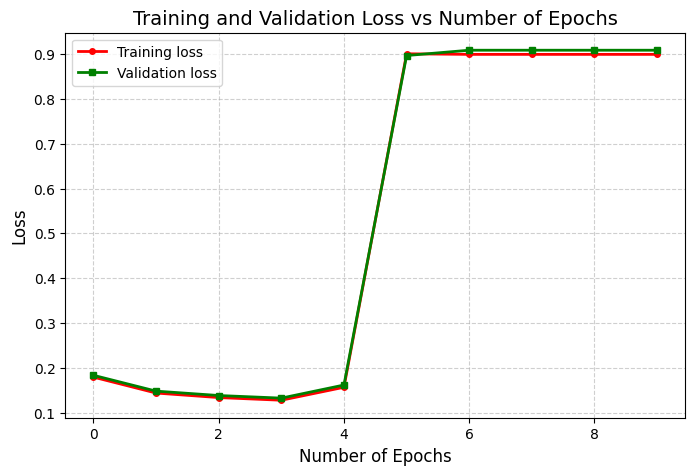

wandb: WARNING Calling wandb.run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


accuracy,▇████▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
loss,▁▁▁▁▁█████
val_accuracy,▇████▁▁▁▁▁
val_loss,▁▁▁▁▁█████
accuracy,0.10093
epoch,11
loss,0.89907
val_accuracy,0.09167
val_loss,0.90833


wandb: Agent Starting Run: ltwjx9t5 with config:
wandb: 	L2_lamb: 0.0005
wandb: 	activation_f: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 4
wandb: 	num_neurons: 128
wandb: 	optimizer: nesterov


lr_0.0001_ac_sigmoid_in_xavier_op_nesterov_bs_32_L2_0.0005_ep_10_nn_128_nh_4
Epoch 3: Training Cost = 0.46015131501900064, Validation Cost = 0.46067678568009507
Epoch 5: Training Cost = 0.4583827875580358, Validation Cost = 0.4588845230676938
Epoch 7: Training Cost = 0.45697978857153193, Validation Cost = 0.4574555609619651
Epoch 9: Training Cost = 0.455849317703986, Validation Cost = 0.4562983462669334
Epoch 11: Training Cost = 0.4549267011934103, Validation Cost = 0.4553491123230731

Final training cost: 0.4549267011934103


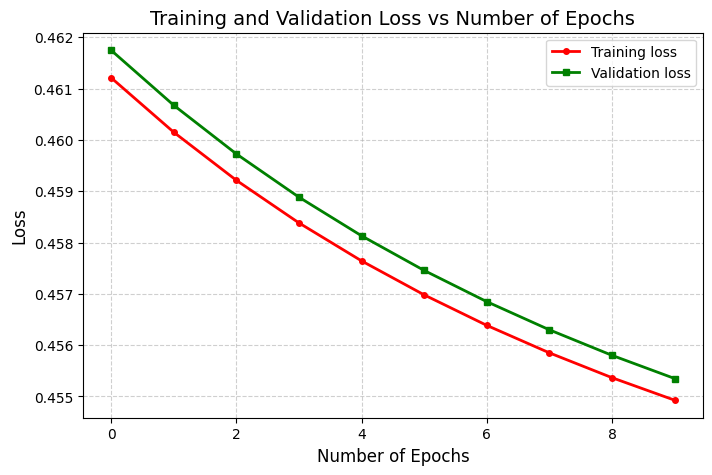

accuracy,▁▁▁▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▇▆▅▄▃▃▂▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▆▅▄▃▃▂▁▁
accuracy,0.09965
epoch,11
loss,0.45493
val_accuracy,0.10317
val_loss,0.45535


wandb: Agent Starting Run: wwh0iz57 with config:
wandb: 	L2_lamb: 0
wandb: 	activation_f: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	init_mode: random
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 3
wandb: 	num_neurons: 64
wandb: 	optimizer: sgd


lr_0.001_ac_sigmoid_in_random_op_sgd_bs_64_L2_0_ep_5_nn_64_nh_3
Epoch 3: Training Cost = 0.4500384434860986, Validation Cost = 0.4500028549837872
Epoch 5: Training Cost = 0.4500229866314746, Validation Cost = 0.4499986964489518

Final training cost: 0.4500176838807887


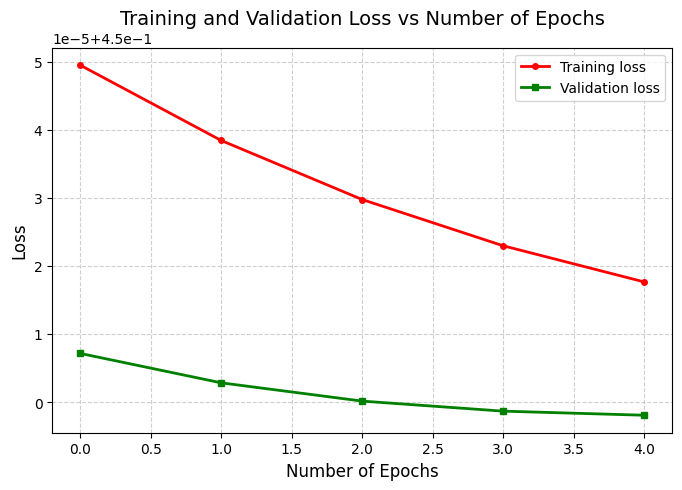

accuracy,▁▁▁▁▁
epoch,▁▃▅▆█
loss,█▆▄▂▁
val_accuracy,▁▁▁▁▁
val_loss,█▅▃▁▁
accuracy,0.10019
epoch,6
loss,0.45002
val_accuracy,0.09833
val_loss,0.45


wandb: Agent Starting Run: p9sqwx62 with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	init_mode: random
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 4
wandb: 	num_neurons: 32
wandb: 	optimizer: RMSprop


lr_0.001_ac_relu_in_random_op_RMSprop_bs_64_L2_0.5_ep_5_nn_32_nh_4
Epoch 3: Training Cost = 0.4500003406962088, Validation Cost = 0.4500073817991315
Epoch 5: Training Cost = 0.45000036747752775, Validation Cost = 0.45000747313928174

Final training cost: 0.45000036780941016


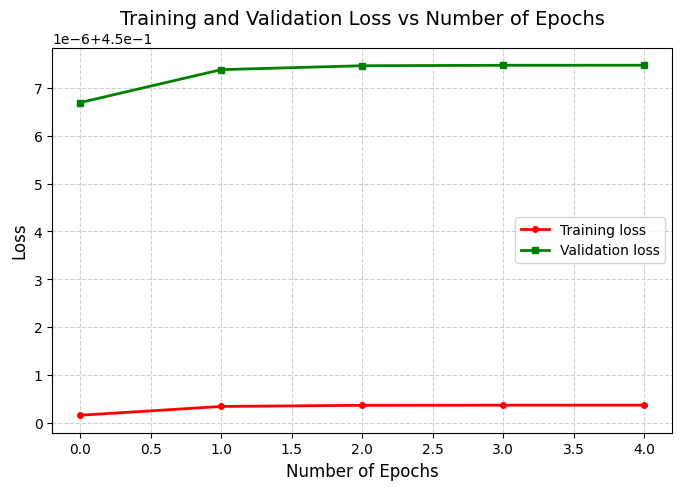

accuracy,▁▁▁▁▁
epoch,▁▃▅▆█
loss,▁▇███
val_accuracy,▁▁▁▁▁
val_loss,▁▇███
accuracy,0.10006
epoch,6
loss,0.45
val_accuracy,0.0995
val_loss,0.45001


wandb: Agent Starting Run: c5y68rvr with config:
wandb: 	L2_lamb: 0
wandb: 	activation_f: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 4
wandb: 	num_neurons: 64
wandb: 	optimizer: adam


lr_0.0001_ac_sigmoid_in_xavier_op_adam_bs_32_L2_0_ep_5_nn_64_nh_4
Epoch 3: Training Cost = 0.44990328813715763, Validation Cost = 0.44986563001959445
Epoch 5: Training Cost = 0.44971956693151177, Validation Cost = 0.44968540148570857

Final training cost: 0.4495822948839455


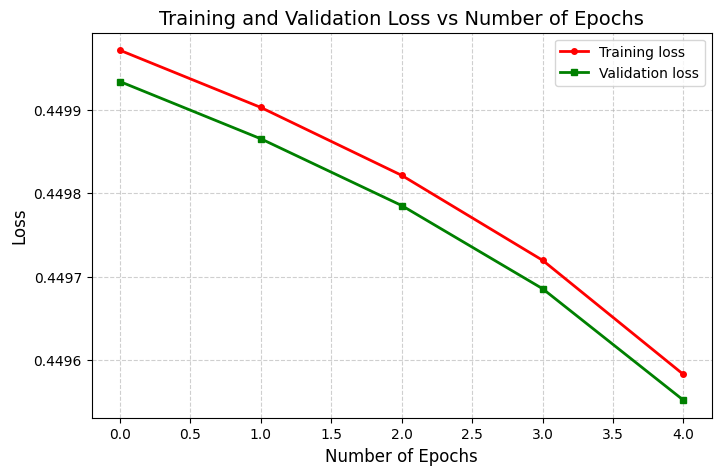

accuracy,▁▁▃█▆
epoch,▁▃▅▆█
loss,█▇▅▃▁
val_accuracy,▁▁▄█▆
val_loss,█▇▅▃▁
accuracy,0.11883
epoch,6
loss,0.44958
val_accuracy,0.11717
val_loss,0.44955


wandb: Agent Starting Run: otvoz3x6 with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	init_mode: random
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 4
wandb: 	num_neurons: 32
wandb: 	optimizer: nesterov


lr_0.0001_ac_sigmoid_in_random_op_nesterov_bs_16_L2_0.5_ep_5_nn_32_nh_4
Epoch 3: Training Cost = 0.4500357371443048, Validation Cost = 0.4501342593556191
Epoch 5: Training Cost = 0.4500321605010144, Validation Cost = 0.45012755359076195

Final training cost: 0.4500305298089632


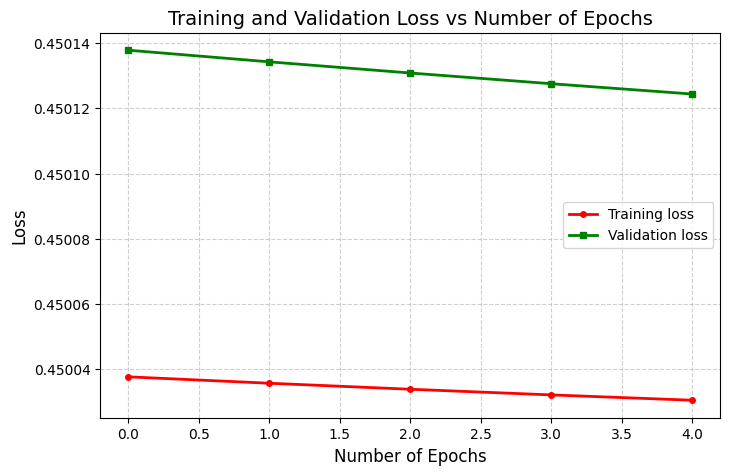

accuracy,▁▁▁▁▁
epoch,▁▃▅▆█
loss,█▆▄▃▁
val_accuracy,▁▁▁▁▁
val_loss,█▆▄▃▁
accuracy,0.10019
epoch,6
loss,0.45003
val_accuracy,0.09833
val_loss,0.45012


wandb: Agent Starting Run: 0y0vhl4a with config:
wandb: 	L2_lamb: 0
wandb: 	activation_f: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	init_mode: random
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 4
wandb: 	num_neurons: 32
wandb: 	optimizer: adam


lr_0.0001_ac_relu_in_random_op_adam_bs_64_L2_0_ep_10_nn_32_nh_4
Epoch 3: Training Cost = 0.44999980974404913, Validation Cost = 0.4500025163750596
Epoch 5: Training Cost = 0.4499996874889271, Validation Cost = 0.45000533291370864
Epoch 7: Training Cost = 0.44999965322779006, Validation Cost = 0.45000670905136897
Epoch 9: Training Cost = 0.44999964263710523, Validation Cost = 0.4500073273490279
Epoch 11: Training Cost = 0.44999963880186117, Validation Cost = 0.45000759767507875

Final training cost: 0.44999963880186117


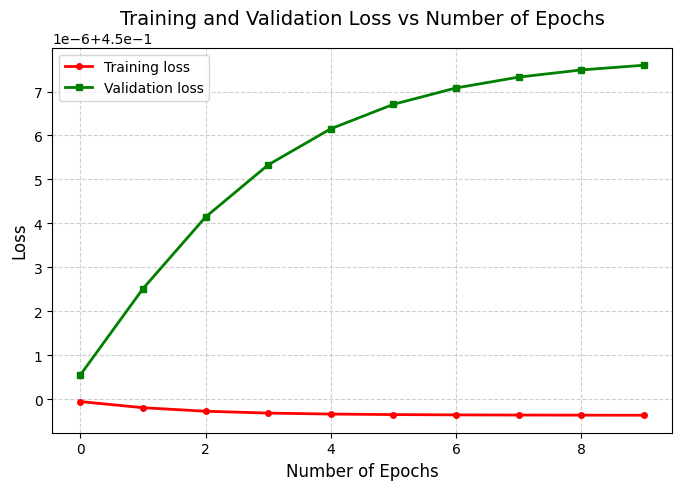

accuracy,▁▁▁▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▃▂▂▂▂▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁
val_loss,▁▃▅▆▇▇▇███
accuracy,0.10019
epoch,11
loss,0.45
val_accuracy,0.09833
val_loss,0.45001


wandb: Agent Starting Run: y97lu3wu with config:
wandb: 	L2_lamb: 0
wandb: 	activation_f: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 5
wandb: 	num_neurons: 64
wandb: 	optimizer: sgd


lr_0.001_ac_relu_in_xavier_op_sgd_bs_64_L2_0_ep_10_nn_64_nh_5
Epoch 3: Training Cost = 0.4490218449306722, Validation Cost = 0.44913873433890833
Epoch 5: Training Cost = 0.4471020824118568, Validation Cost = 0.4472510847605312
Epoch 7: Training Cost = 0.44496103424144406, Validation Cost = 0.44514467614381065
Epoch 9: Training Cost = 0.44232312435538557, Validation Cost = 0.44253645142779335
Epoch 11: Training Cost = 0.4389915083211388, Validation Cost = 0.4392565059579997

Final training cost: 0.4389915083211388


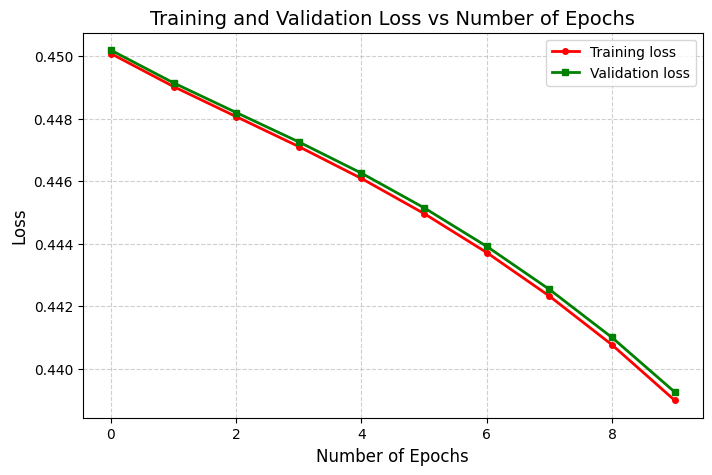

accuracy,▁▃▄▆▇▇████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▇▇▆▅▅▄▃▂▁
val_accuracy,▁▃▄▆▇▇████
val_loss,█▇▇▆▅▅▄▃▂▁
accuracy,0.35691
epoch,11
loss,0.43899
val_accuracy,0.347
val_loss,0.43926


wandb: Agent Starting Run: rywelhqj with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	init_mode: random
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 3
wandb: 	num_neurons: 64
wandb: 	optimizer: sgd


lr_0.0001_ac_tanh_in_random_op_sgd_bs_16_L2_0.5_ep_5_nn_64_nh_3
Epoch 3: Training Cost = 0.4500255757729209, Validation Cost = 0.45023493130118997
Epoch 5: Training Cost = 0.450024515095419, Validation Cost = 0.45022532340383126

Final training cost: 0.450024001530287


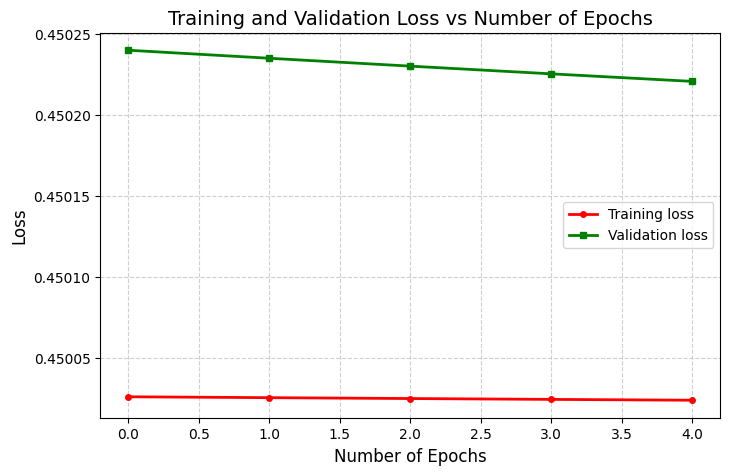

accuracy,▁▃▆█▇
epoch,▁▃▅▆█
loss,█▆▄▃▁
val_accuracy,▁▃▇█▇
val_loss,█▆▄▃▁
accuracy,0.10693
epoch,6
loss,0.45002
val_accuracy,0.09783
val_loss,0.45022


wandb: Agent Starting Run: nx5jpf25 with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 3
wandb: 	num_neurons: 32
wandb: 	optimizer: momentum


lr_0.001_ac_tanh_in_xavier_op_momentum_bs_32_L2_0.5_ep_10_nn_32_nh_3
Epoch 3: Training Cost = 0.4246218185189553, Validation Cost = 0.428009012135068
Epoch 5: Training Cost = 0.4047267723361449, Validation Cost = 0.40798278876369776
Epoch 7: Training Cost = 0.3894517298138399, Validation Cost = 0.3926078374977652
Epoch 9: Training Cost = 0.37706769507866755, Validation Cost = 0.38014995661343215
Epoch 11: Training Cost = 0.3667773122233671, Validation Cost = 0.3698234054901085

Final training cost: 0.3667773122233671


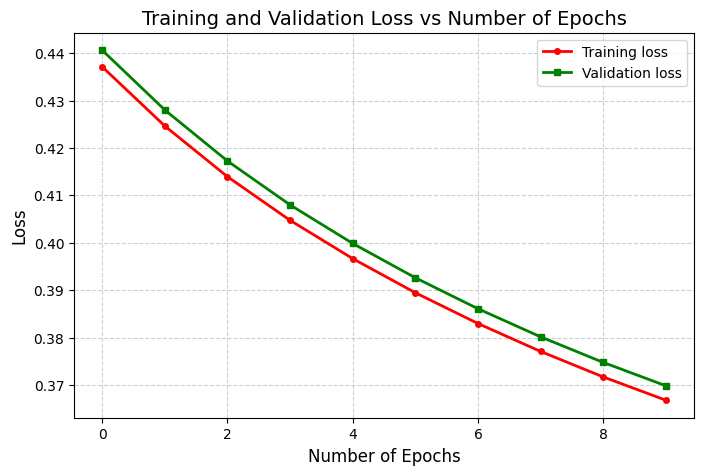

accuracy,▁▃▅▆▆▇▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▇▆▅▄▃▃▂▁▁
val_accuracy,▁▃▅▆▆▇▇███
val_loss,█▇▆▅▄▃▃▂▁▁
accuracy,0.55848
epoch,11
loss,0.36678
val_accuracy,0.5525
val_loss,0.36982


In [21]:
sweep_config = {
  "name": "Cross Entropy Loss",
  "metric": {
      "name": "val_accuracy",
      "goal": "maximize"
  },
  "method": "random",
  "parameters": {
        "learning_rate": {
            "values": [0.001, 0.0001]
        },
        "activation_f": {
            "values": ["sigmoid", "relu", "tanh"]
        },
        "init_mode": {
            "values": ["random", "xavier"]
        },
        "optimizer": {
            "values": ["sgd", "momentum", "nesterov", "adam", "nadam", "RMSprop"]
        },
        "batch_size": {
            "values": [16, 32, 64]
        },
        "epochs": {
            "values": [5, 10]
        },
        "L2_lamb": {
            "values": [0, 0.0005, 0.5]
        },
        "num_neurons": {
            "values": [32, 64, 128]
        },
        "num_hidden": {
            "values": [3, 4, 5]
        }
    }
}

sweep_id = wandb.sweep(sweep_config, project="Hyperparameter Sweeps")
wandb.agent(sweep_id, NN_fit, count=10)

# **The best hyperparameters**

1st configuration parameters

In [35]:
LEARNING_RATE = 0.001
ACTIVATION = "tanh"
INITIALIZER = "random_normal"
OPTIMIZER = "nadam"
BATCH_SIZE = 512
EPOCHS = 20
L2_lambda = 0
NUM_NEURONS = 128
NUM_HIDDEN = 3
LOSS = 'categorical_crossentropy'

2nd configuration parameters

In [45]:
LEARNING_RATE = 0.001
ACTIVATION = "tanh"
INITIALIZER = "xavier"
OPTIMIZER = "nadam"
BATCH_SIZE = 512
EPOCHS = 60
L2_lambda = 0.5
NUM_NEURONS = 128
NUM_HIDDEN = 6
LOSS = 'categorical_crossentropy'

3rd configuration parameters

In [49]:
LEARNING_RATE = 0.00005
ACTIVATION = "tanh"
INITIALIZER = "xavier"
OPTIMIZER = "sgd"
BATCH_SIZE = 16
EPOCHS = 60
L2_lambda = 0.0005
NUM_NEURONS = 512
NUM_HIDDEN = 6
LOSS = 'categorical_crossentropy'

# **Training the neural network with the best hyperparameters**

In [46]:
def NN_best_fit(X_train, y_train_one_hot, num_features, num_classes, learning_rate=0.001, activation_f='tanh',
                init_mode='xavier', optimizer='adam', batch_size=512, loss='categorical_crossentropy',
                epochs=20, L2_lamb=0, num_neurons=64, num_hidden=3):
    """Train the neural network using the best set of hyperparameters."""

    layer_dims = [num_features] + [num_neurons] * num_hidden + [num_classes]

    params, previous_updates = init_nn_parameters(layer_dims, init_mode)
    epoch_cost = []

    count = 1
    t = 1  # Initialize timestep for Adam optimizer
    v = previous_updates.copy()
    m = previous_updates.copy()
    params_look_ahead = params.copy()
    beta = 0.9

    while count <= epochs:
        count += 1
        for i in range(0, X_train.shape[1], batch_size):
            batch_end = min(i + batch_size, X_train.shape[1])  # Ensure batch doesn't exceed dataset size

            X_batch = X_train[:, i:batch_end]
            y_batch = y_train_one_hot[:, i:batch_end]
            batch_count = batch_end - i

            if optimizer == 'nesterov':
                for l in range(1, len(params) // 2 + 1):
                    params_look_ahead[f"W{l}"] = params[f"W{l}"] - beta * previous_updates[f"W{l}"]
                    params_look_ahead[f"b{l}"] = params[f"b{l}"] - beta * previous_updates[f"b{l}"]

                output, A, Z = forward_propagation_nn(X_batch, params_look_ahead, activation_f)
                gradients = compute_gradients_backprop(output, y_batch, A, Z, params_look_ahead, activation_f, batch_count, loss, L2_lamb)
                params, previous_updates = momentum(params, gradients, learning_rate, beta, previous_updates)

            elif optimizer == 'nadam':
                for l in range(1, len(params) // 2 + 1):
                    params_look_ahead[f"W{l}"] = params[f"W{l}"] - beta * previous_updates[f"W{l}"]
                    params_look_ahead[f"b{l}"] = params[f"b{l}"] - beta * previous_updates[f"b{l}"]

                output, A, Z = forward_propagation_nn(X_batch, params_look_ahead, activation_f)
                gradients = compute_gradients_backprop(output, y_batch, A, Z, params_look_ahead, activation_f, batch_count, loss, L2_lamb)
                params, v, m, t = adam(params, gradients, learning_rate, v, m, t)

            else:
                output, A, Z = forward_propagation_nn(X_batch, params, activation_f)
                gradients = compute_gradients_backprop(output, y_batch, A, Z, params, activation_f, batch_count, loss, L2_lamb)

                if optimizer == 'sgd':
                    params = sgd(params, gradients, learning_rate)
                elif optimizer == 'momentum':
                    params, previous_updates = momentum(params, gradients, learning_rate, beta, previous_updates)
                elif optimizer == 'RMSprop':
                    params, previous_updates = RMSprop(params, gradients, learning_rate, beta, previous_updates)
                elif optimizer == 'adam':
                    params, v, m, t = adam(params, gradients, learning_rate, v, m, t)

        # Compute epoch loss
        full_output, _, _ = forward_propagation_nn(X_train, params, activation_f)
        cost = compute_loss_multi(y_train_one_hot, full_output, X_train.shape[1], loss, L2_lamb, params)

        if count % 2 == 0:
            print(f"Epoch {count}: Training cost = {cost}")

        epoch_cost.append(cost)

    # Plot training loss
    plt.plot(range(len(epoch_cost)), epoch_cost, 'r', label="Training loss")
    plt.title("Training Loss vs Number of Epochs", fontsize=14)
    plt.xlabel("Number of epochs", fontsize=14)
    plt.ylabel("Loss", fontsize=14)
    plt.grid()
    plt.legend()
    plt.show()

    return params, epoch_cost


In [ ]:
# Fit model with correct inputs
learned_parameters, epoch_cost = NN_best_fit(
    X_train, y_train_one_hot,
    num_features=X_train.shape[0],
    num_classes=num_classes,
    learning_rate=LEARNING_RATE,
    activation_f=ACTIVATION,
    init_mode=INITIALIZER,
    optimizer=OPTIMIZER,
    batch_size=BATCH_SIZE,
    loss=LOSS,
    epochs=EPOCHS,
    L2_lamb=L2_lambda,
    num_neurons=NUM_NEURONS,
    num_hidden=NUM_HIDDEN
)


Epoch 2: Training cost = 1.803143133835356
Epoch 4: Training cost = 1.2288462675915062
Epoch 6: Training cost = 0.9976760068088111
Epoch 8: Training cost = 0.8735715198052674
Epoch 10: Training cost = 0.794305074688155
Epoch 12: Training cost = 0.7382533468116573


# **Accuracy on test and train data with learned parameters**

In [48]:
train_predictions, test_predictions = evaluate_nn(
    X_train, y_train,
    X_test, y_test,
    learned_parameters, ACTIVATION
)


Training Accuracy: 84.128 %
Test Accuracy: 82.45 %

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.79      0.83      0.81      1000
           1       0.90      0.98      0.94      1000
           2       0.67      0.82      0.74      1000
           3       0.94      0.75      0.83      1000
           4       0.60      0.77      0.68      1000
           5       0.98      0.90      0.94      1000
           6       0.65      0.36      0.46      1000
           7       0.84      0.99      0.91      1000
           8       0.95      0.96      0.96      1000
           9       0.97      0.89      0.93      1000

    accuracy                           0.82     10000
   macro avg       0.83      0.82      0.82     10000
weighted avg       0.83      0.82      0.82     10000



# **Plotting confusion matrices for test and train data**

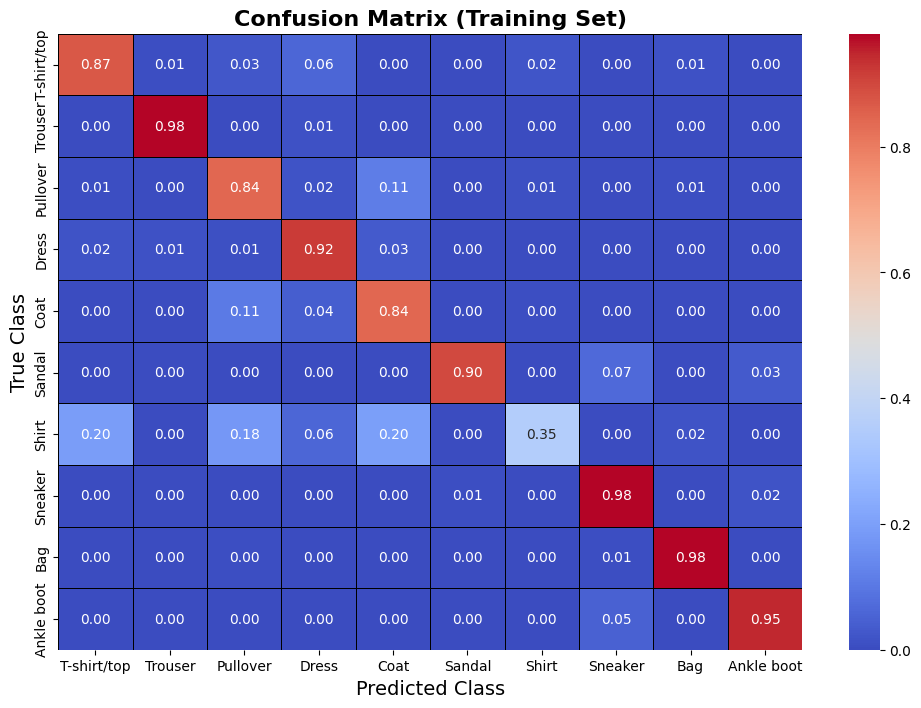

In [43]:
# Convert one-hot encoded labels to class labels
y_train_labels = np.argmax(y_train_one_hot, axis=0)
train_predictions_labels = np.asarray(train_predictions)

# Compute confusion matrix for training set
train_cm = confusion_matrix(y_train_labels, train_predictions_labels, normalize='true')

# Plot confusion matrix
plt.figure(figsize=(12, 8))
ax = sns.heatmap(train_cm, annot=True, fmt=".2f", cmap="coolwarm",
                 xticklabels=class_names, yticklabels=class_names, linewidths=0.5, linecolor='black')

# Set title and labels
ax.set_title("Confusion Matrix (Training Set)", fontsize=16, fontweight='bold')
ax.set_xlabel("Predicted Class", fontsize=14)
ax.set_ylabel("True Class", fontsize=14)

# Save and display plot
plt.savefig("train_conf_matrix.png", dpi=300, bbox_inches="tight")
plt.show()


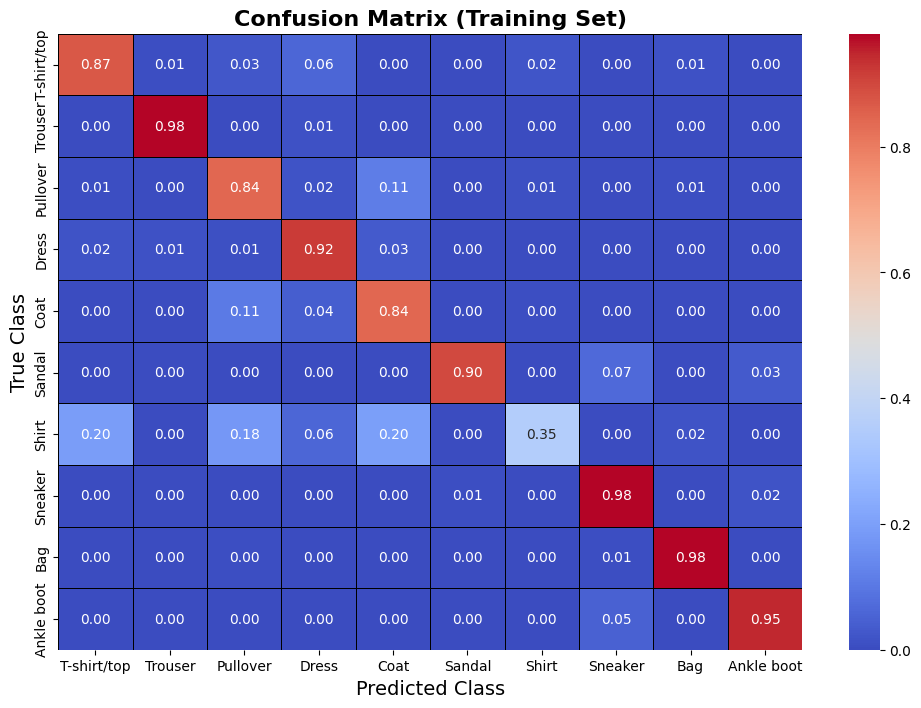

In [44]:
# Compute confusion matrix for training set
train_cm = confusion_matrix(y_train_labels, train_predictions_labels, normalize='true')

# Plot confusion matrix
plt.figure(figsize=(12, 8))
ax = sns.heatmap(train_cm, annot=True, fmt=".2f", cmap="coolwarm",
                 xticklabels=class_names, yticklabels=class_names,
                 linewidths=0.5, linecolor='black')

# Set title and labels
ax.set_title("Confusion Matrix (Training Set)", fontsize=16, fontweight='bold')
ax.set_xlabel("Predicted Class", fontsize=14)
ax.set_ylabel("True Class", fontsize=14)

# Save and display plot
plt.savefig("train_conf_matrix.png", dpi=300, bbox_inches="tight")
plt.show()
